In [10]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy import stats
import scipy.io as sio
import seaborn as sns

In [11]:
# load gene expression data
row_expr_table = pd.read_csv('connectivity_analysis/gene_expr_data/070120_Conn_matching_no_over_expression_averaged_neuron.csv')

display(row_expr_table)

,Unnamed: 0,ADA,ADE,ADF,ADL,AFD,AIA,AIB,AIM,AIN,...,URX,URY,VA,VA12,VB,VB01,VB02,VC,VC_4_5,VD_DD
0,nduo-6,6.572607,11.129103,3.168643,3.305759,6.269388,4.227092,4.228806,4.912409,6.419540,...,9.469484,13.670732,9.177479,9.951220,11.586478,8.929714,6.999235,3.973783,3.666667,7.477377
1,ndfl-4,0.844884,1.137856,0.519104,0.433508,1.204082,0.637450,0.416591,0.613139,0.593870,...,0.687793,1.792683,0.771114,0.682927,0.735849,0.534028,0.471128,0.375281,0.156863,0.738361
2,MTCE.7,0.879538,1.319475,0.150198,0.142408,0.367347,0.346614,0.219690,0.404380,0.452107,...,0.765258,0.560976,0.832313,1.390244,1.410377,1.134251,0.860803,0.444195,0.254902,0.649180
3,nduo-1,1.339934,0.503282,0.577075,1.178010,2.134694,0.808765,0.976299,0.775182,0.467433,...,0.326291,4.451220,1.031824,1.024390,0.838836,0.589810,0.647036,0.691386,0.696078,0.867541
4,atp-6,3.775578,4.529540,2.557312,1.877487,3.848980,3.099602,2.618049,2.237956,2.478927,...,3.215962,8.158537,4.002448,2.829268,3.544811,2.476013,2.444742,2.190262,2.225490,4.721967
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13653,C50D2.3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.097561,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13654,gst-35,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.658537,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13655,C28C12.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.147059,0.000000
13656,T12F5.2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.303922,0.000000


In [12]:
# extract neuron names, gene names and gene expression profiles
row_expr_neurons = row_expr_table.columns[1:].to_numpy()
row_expr_genes = row_expr_table.iloc[:,0].to_numpy()
row_expr_matrix = row_expr_table.iloc[:,1:].to_numpy()
G = row_expr_matrix.T

print(row_expr_neurons.shape)
print(row_expr_genes.shape)
print(G.shape)

(127,)
(13658,)
(127, 13658)


In [13]:
# load CAM genes' names
cams = sio.loadmat('connectivity_analysis/gene_sets/cams.mat')
gene_set = [cam[0][0] for cam in cams['cams']]

print(len(gene_set))

# find CAM genes' indexes
gene_idxs = np.isin(row_expr_genes, gene_set)

141


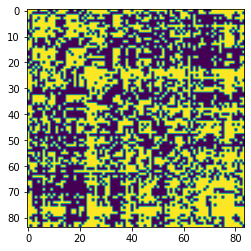

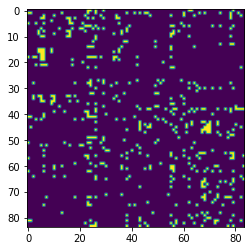

In [14]:
# load the contactome
feasible_connectome = np.loadtxt('connectivity_analysis/connectome_data/102820_nerve_ring_adjacency.csv', delimiter=',') > 0

plt.figure()
plt.imshow(feasible_connectome)
plt.show()

# load the connectome
connectome = np.loadtxt('connectivity_analysis/connectome_data/102820_nerve_ring_connectome.csv', delimiter=',') > 0 # NOTE: pre in rows, post in column

plt.figure()
plt.imshow(connectome)
plt.show()

# load the contactome/connectome neuron names
adjacency_row_neurons = np.loadtxt('connectivity_analysis/connectome_data/102820_nerve_ring_adjacency_row_neurons.csv', dtype=str)

# find indexes of neurons that are in the contactome/connectome
neuron_idxs = np.nonzero(np.isin(row_expr_neurons, adjacency_row_neurons))[0]

In [15]:
# align gene expression and connectivity data
G = G[:,gene_idxs]
G = G[neuron_idxs]

In [16]:
# find neuron pairs that exhibit synapses
pre, post = np.nonzero(connectome)

# find pairs of adjacent neurons with no synapses
adj_pre, adj_post = np.nonzero(feasible_connectome ^ connectome)

beta = np.zeros((len(gene_set), len(gene_set)))
pval = np.zeros_like(beta)
for u in range(len(gene_set)):
    for v in range(len(gene_set)):
        # compute gene co-expression for connected and adjacent neuron pairs
        gene_interaction_1 = np.log1p(G[pre,u]*G[post,v])
        gene_interaction_2 = np.log1p(G[adj_pre,u]*G[adj_post,v])
        
        # store the log-fold change
        beta[u,v] = gene_interaction_1.mean() - gene_interaction_2.mean()

        # test whether the two samples have identical average values
        pval[u,v] = stats.ttest_ind(gene_interaction_1, gene_interaction_2).pvalue

# p-value correction
pval *= len(gene_set)**2

In [17]:
p_threshold = 0.05

# set significant positive betas as the genetic rules
sig_beta = np.zeros_like(beta)
sig_beta[pval<=p_threshold] = beta[pval<=p_threshold]
O = sig_beta > 0
print('# of genetic rules:', O.sum())

# remove genes that do not interact in synapse formation
coexp_idxs = np.nonzero((O+O.T).sum(axis=0))[0]
O = O[coexp_idxs][:,coexp_idxs]
gene_names = row_expr_genes[gene_idxs][coexp_idxs]
print('final O shape:', O.shape)

# save genetic rules to file
# np.savez('data/genetic_rules.npz', O=O, gene_names=gene_names)

# of genetic rules: 47
final O shape: (39, 39)


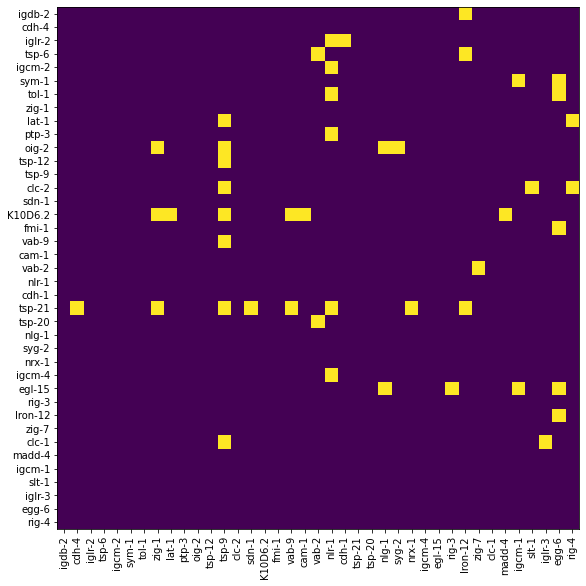

In [18]:
npz = np.load('data/genetic_rules.npz', allow_pickle=True)
O = npz['O']
gene_names = npz['gene_names']

# show the genetic rules
scale = 2
plt.figure(figsize=(scale*4.8, scale*4.8))
plt.imshow(O)
plt.xticks(range(len(gene_names)), gene_names, rotation=90)
plt.yticks(range(len(gene_names)), gene_names)
plt.show()